# Airfoil Surface RANS
We solve the compressible Navier–Stokes equations using the Reynolds-Averaged Navier–Stokes (RANS) approach, closed with the Spalart–Allmaras (SA) turbulence model, implemented in the SU2 solver (check [here](https://su2code.github.io/docs_v7/Theory/) for more details). The simulations are performed at a free-stream Mach number of 0.25.  

### Overview
- Airfoils: 1433 different geometries

- Angles of attack (AoA): -5°～10°

- After removing problematic or non-convergent cases: 18186 samples remain

- Stored data: only boundary nodes and boundary features, plus lift and drag coefficients

### Data Format
- global_features.npz → case-wise global data, shape (N_samples,)
	- ['name']: airfoil name
	- ['aoa']: angle of attack
	- ['cl']: lift coefficient $C_L$
	- ['cd]: drag coefficient $C_D$

- nodes_xxxxx.npy → boundary node coordinates, shape (n_nodes, 2)

- features_xxxxx.npy → boundary features, shape (n_nodes, 3)
    - [..., 0]: pressure coefficient $C_P$
    - [..., 1]: x-component of skin friction coefficient $C_{f,x}$
    - [..., 2]: y-component of skin friction coefficient $C_{f,y}$

nnodes = 600 for all samples

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

DATA_PATH = Path('./raw_data/')

global_features = np.load(DATA_PATH / 'global_features.npz')
airfoil_names = global_features['name']
airfoil_aoas = global_features['aoa']
airfoil_cls = global_features['cl']
airfoil_cds = global_features['cd']


def plot_sample(nodes, features, name, aoa, equal_axis=False):
    key_list = [r'$C_P$', r'$C_{f,x}$', r'$C_{f,y}$']

    x, y = nodes[:, 0], nodes[:, 1]
    
    fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
    for j in range(3):
        axs[j].plot(x, features[:,j])
        axs[j].set_title(key_list[j])
    fig.suptitle(f"Airofil {name}, AoA={aoa}°", fontsize=16)

    fig, axs = plt.subplots(1, 3, figsize=(25, 3))  
    for j in range(3):
        sc = axs[j].scatter(x, y, c=features[:, j], cmap='viridis', s=2.5)

        axs[j].axis('off')

        if equal_axis:
            axs[j].set_aspect('equal')

        cbar = fig.colorbar(sc, ax=axs[j], shrink=0.8)
        cbar.set_label(key_list[j], fontsize=12)

### Distribution of AoA

Total valid samples: 18186


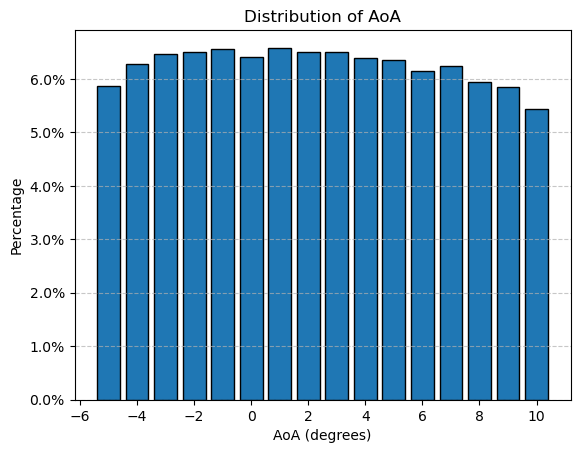

In [2]:
angles = range(-5, 11)
counts = {aoa: 0 for aoa in angles}
for aoa in airfoil_aoas:
    counts[aoa] += 1
counts = np.array(list(counts.values()))

n_data = np.sum(counts)
print(f"Total valid samples: {n_data}")

plt.bar(angles, counts * 100 / n_data, edgecolor='k')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Distribution of AoA')
plt.xlabel('AoA (degrees)')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.show()

### Distribution of $C_L / C_D$

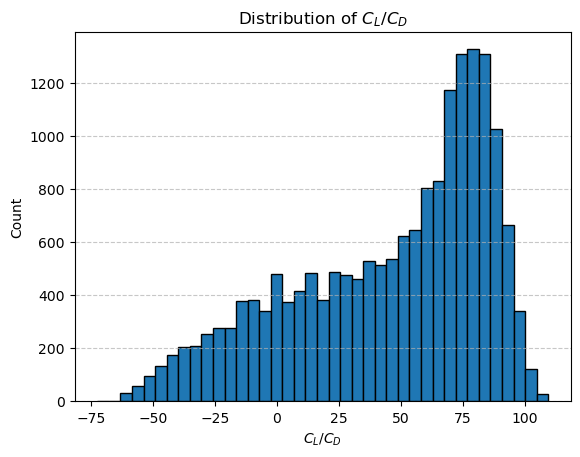

In [3]:
plt.hist(airfoil_cls / airfoil_cds, bins='auto', edgecolor="k")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title(f"Distribution of $C_L/C_D$")
plt.xlabel('$C_L/C_D$')
plt.ylabel("Count")
plt.show()

### Samples

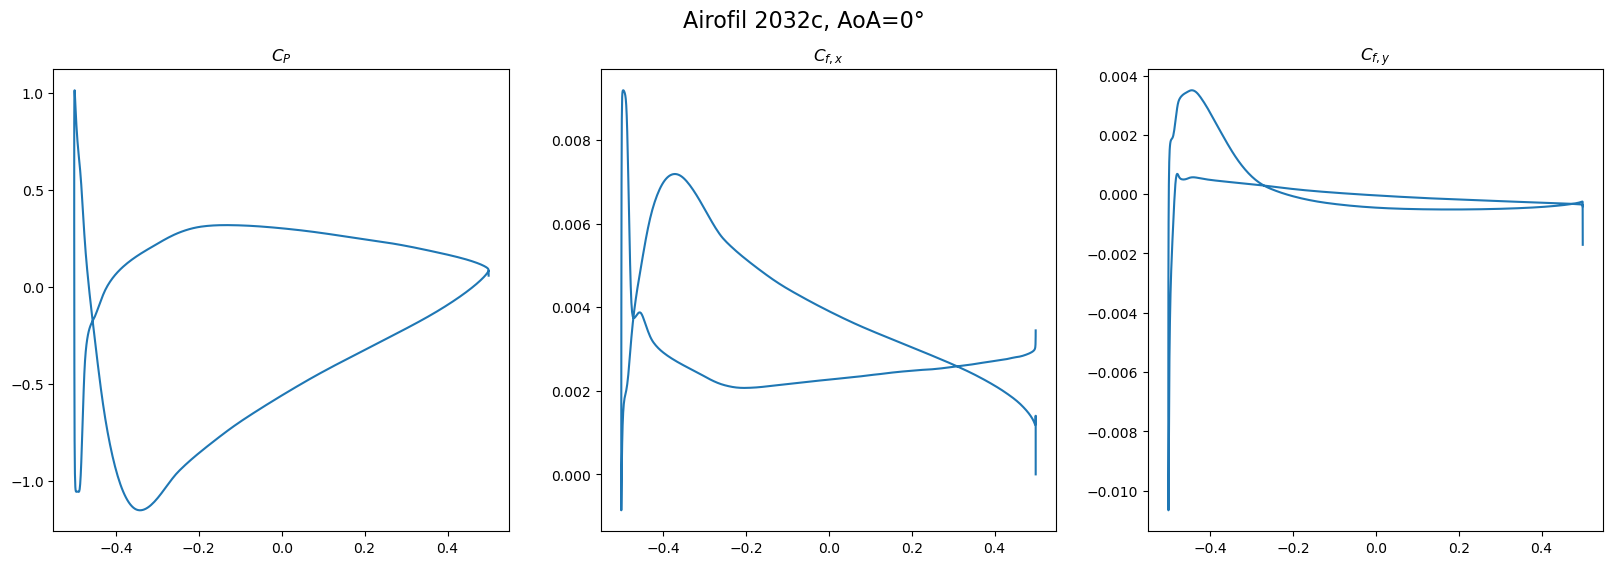

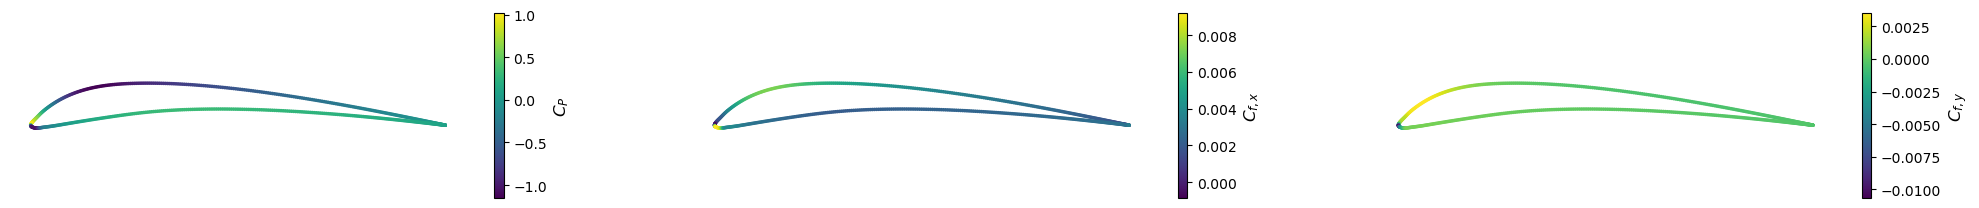

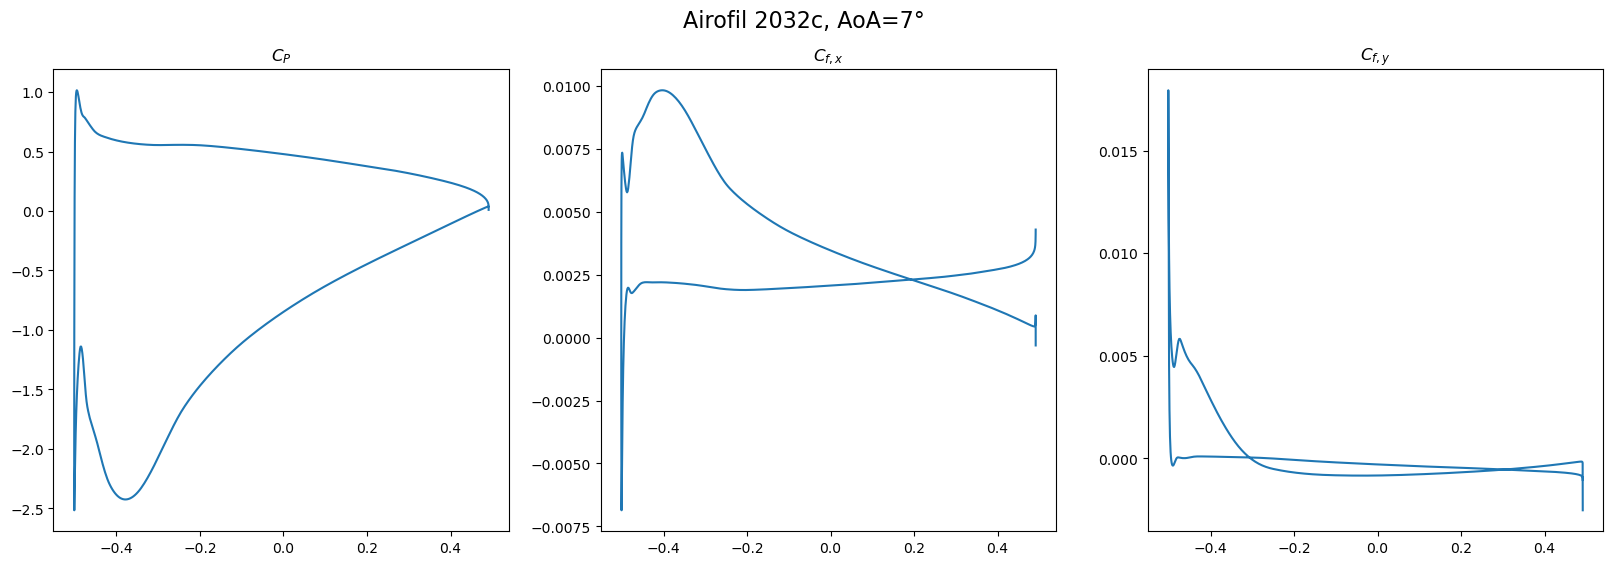

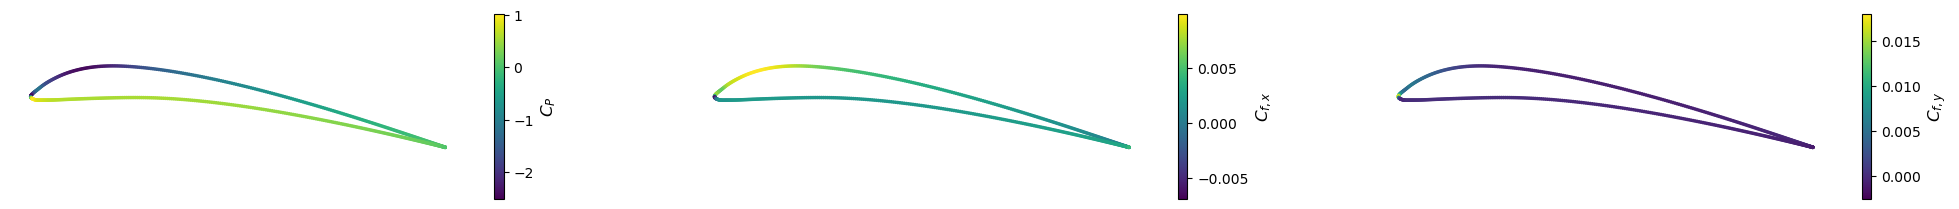

In [8]:
showcase_list = [3, 10]

for idx in showcase_list:
    name, aoa = airfoil_names[idx], airfoil_aoas[idx]
    nodes = np.load(DATA_PATH / f'nodes_{idx:05d}.npy')
    features = np.load(DATA_PATH / f'features_{idx:05d}.npy')
    plot_sample(nodes, features, name, aoa, equal_axis=True)
    plt.show()

### Computing $C_L$ and $C_D$ from Surface Features
$C_L$ is mainly determined by the pressure and $C_D$ includes both form pressure and skin-friction drag.
$$ C_L = \int_\Gamma \big[ (-C_p n_y) + C_{f,y} \big]\,ds$$
$$ C_D = \int_\Gamma \big[ (-C_p n_x) + C_{f,x} \big]\,ds $$


Notes: Ensure boundary nodes are ***ordered*** around the surface if you want to use the functions below  

In [5]:
def compute_press_force(nodes, cp):

    cp = cp.reshape(-1)

    n = len(nodes)
    idx = np.arange(n)
    idx_next = (idx + 1) % n

    segs = nodes[idx_next] - nodes[idx]
    dx = segs[:, 0]
    dy = segs[:, 1]

    nx_times_length = dy
    ny_times_length = -dx

    p_avg = 0.5 * (cp[idx_next] + cp[idx])

    fx = -p_avg * nx_times_length
    fy = -p_avg * ny_times_length

    drag = fx.sum()
    lift = fy.sum()

    return lift, drag


def compute_friction(nodes, cf):

    n = len(nodes)
    idx = np.arange(n)
    idx_next = (idx + 1) % n

    segs = nodes[idx_next] - nodes[idx]
    ds = np.linalg.norm(segs, axis=1)

    f_avg = 0.5 * (cf[idx_next] + cf[idx])

    drag = np.sum(f_avg[:, 0] * ds)
    lift = np.sum(f_avg[:, 1] * ds)

    return lift, drag

In [6]:
idx = 0
name, aoa = airfoil_names[idx], airfoil_aoas[idx]
print(f'Airfoil {name}, AoA={aoa}')

cl = airfoil_cls[idx]
cd = airfoil_cds[idx]
nodes = np.load(DATA_PATH / f'nodes_{idx:05d}.npy')
features = np.load(DATA_PATH / f'features_{idx:05d}.npy')
cp = features[:, [0]]
cf = features[:, 1:]

c_press_lift, c_press_drag = compute_press_force(nodes, cp)
c_friction_lift, c_friction_drag = compute_friction(nodes, cf)
print(c_press_lift, c_press_drag, c_friction_lift, c_friction_drag)

cl_recovered = c_press_lift + c_friction_lift
cd_recovered = c_press_drag + c_friction_drag
print(f"\nGT from SU2: CL={cl:.10f}, CD={cd:.10f}")
print(f"Recovered from features: CL={cl_recovered:.10f}, CD={cd_recovered:.10f}")

Airfoil 2032c, AoA=-3
0.3359909 0.0034546778 0.00021354365 0.006194466

GT from SU2: CL=0.3362033661, CD=0.0096495897
Recovered from features: CL=0.3362044394, CD=0.0096491436
